# Feature selection with null importances

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, chi2_contingency, ttest_ind
# automated feature engineering
import featuretools as ft

# Filter out pandas warnings
import warnings 
warnings.filterwarnings('ignore')

start = "\033[1m"  # Bold text
end = "\033[0;0m"  # Reset text
from IPython.core.interactiveshell import InteractiveShell
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
import time
from lightgbm import LGBMClassifier
import lightgbm as lgb

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import os

%matplotlib inline

import warnings
warnings.simplefilter('ignore', UserWarning)
InteractiveShell.ast_node_interactivity = "all"
import sys
sys.path.append('../')
from helpers import *

In [3]:
if os.path.exists("../features_data/feature_matrix.csv"):
    feature_matrix_spec = pd.read_csv("../features_data/feature_matrix.csv")

# load feature names
with open('../features_data/feature_names.txt', 'r') as f:
    feature_names = f.read().splitlines()
    
feature_names[-20:]
feature_matrix_spec.head(10)
feature_matrix_spec = clean_feature_names(feature_matrix_spec)

['<Feature: STD(credit.previous.SELLERPLACE_AREA)>',
 '<Feature: SUM(credit.previous.AMT_ANNUITY)>',
 '<Feature: SUM(credit.previous.AMT_APPLICATION)>',
 '<Feature: SUM(credit.previous.AMT_CREDIT)>',
 '<Feature: SUM(credit.previous.AMT_DOWN_PAYMENT)>',
 '<Feature: SUM(credit.previous.AMT_GOODS_PRICE)>',
 '<Feature: SUM(credit.previous.CNT_PAYMENT)>',
 '<Feature: SUM(credit.previous.DAYS_DECISION)>',
 '<Feature: SUM(credit.previous.DAYS_FIRST_DRAWING)>',
 '<Feature: SUM(credit.previous.DAYS_FIRST_DUE)>',
 '<Feature: SUM(credit.previous.DAYS_LAST_DUE)>',
 '<Feature: SUM(credit.previous.DAYS_LAST_DUE_1ST_VERSION)>',
 '<Feature: SUM(credit.previous.DAYS_TERMINATION)>',
 '<Feature: SUM(credit.previous.HOUR_APPR_PROCESS_START)>',
 '<Feature: SUM(credit.previous.NFLAG_INSURED_ON_APPROVAL)>',
 '<Feature: SUM(credit.previous.NFLAG_LAST_APPL_IN_DAY)>',
 '<Feature: SUM(credit.previous.RATE_DOWN_PAYMENT)>',
 '<Feature: SUM(credit.previous.RATE_INTEREST_PRIMARY)>',
 '<Feature: SUM(credit.previous.R

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,SUM(credit.previous.DAYS_FIRST_DRAWING),SUM(credit.previous.DAYS_FIRST_DUE),SUM(credit.previous.DAYS_LAST_DUE),SUM(credit.previous.DAYS_LAST_DUE_1ST_VERSION),SUM(credit.previous.DAYS_TERMINATION),SUM(credit.previous.HOUR_APPR_PROCESS_START),SUM(credit.previous.NFLAG_INSURED_ON_APPROVAL),SUM(credit.previous.NFLAG_LAST_APPL_IN_DAY),SUM(credit.previous.RATE_DOWN_PAYMENT),SUM(credit.previous.SELLERPLACE_AREA)
0,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,...,2191458.0,2191458.0,2191458.0,2191458.0,2191458.0,90.0,0.0,6.0,0.0,-6.0
4,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0,Cash loans,M,N,Y,0,99000.0,490495.5,27517.5,454500.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0,Cash loans,F,Y,Y,1,171000.0,1560726.0,41301.0,1395000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0,Cash loans,M,Y,Y,0,360000.0,1530000.0,42075.0,1530000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0,Cash loans,F,N,Y,0,112500.0,1019610.0,33826.5,913500.0,...,-168498.0,-164946.0,-93018.0,27027982.0,27027982.0,740.0,0.0,74.0,0.0,0.0
9,0,Revolving loans,M,N,Y,0,135000.0,405000.0,20250.0,405000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# data = feature_matrix_spec.drop(columns=["set"])

# categorical_feats = [
#     f for f in data.columns if data[f].dtype == 'object' or data[f].dtype.name == 'category'
# ]

# categorical_feats
# for f_ in categorical_feats:
#     data[f_], _ = pd.factorize(data[f_])
#     # Set feature type as categorical
#     data[f_] = data[f_].astype('category')

# def get_feature_importances(data, shuffle, seed=None):
#     # Gather real features
#     train_features = [f for f in data if f not in ['TARGET', 'SK_ID_CURR']]
#     # Go over fold and keep track of CV score (train and valid) and feature importances
    
#     # Shuffle target if required
#     y = data['TARGET'].copy()
#     if shuffle:
#         # Here you could as well use a binomial distribution
#         y = data['TARGET'].copy().sample(frac=1.0)
    
#     # Fit LightGBM in RF mode, yes it's quicker than sklearn RandomForest
#     dtrain = lgb.Dataset(data[train_features], y, free_raw_data=False)
#     lgb_params = {
#         'objective': 'binary',
#         'boosting_type': 'rf',
#         'subsample': 0.623,
#         'colsample_bytree': 0.7,
#         'num_leaves': 127,
#         'max_depth': 8,
#         'seed': seed,
#         'bagging_freq': 1,
#         'n_jobs': 4
#     }
    
#     # Fit the model
#     clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=200, categorical_feature=categorical_feats)

#     # Get feature importances
#     imp_df = pd.DataFrame()
#     imp_df["feature"] = list(train_features)
#     imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
#     imp_df["importance_split"] = clf.feature_importance(importance_type='split')
#     # imp_df['trn_score'] = roc_auc_score(y, clf.predict(data[train_features]), multi_class='ovr')    
#     return imp_df
# # Seed the unexpected randomness of this world
# np.random.seed(123)
# # Get the actual importance, i.e. without shuffling
# actual_imp_df = get_feature_importances(data=data, shuffle=False)
# actual_imp_df.head()
# null_imp_df = pd.DataFrame()
# nb_runs = 80
# import time
# start = time.time()
# dsp = ''
# for i in range(nb_runs):
#     # Get current run importances
#     imp_df = get_feature_importances(data=data, shuffle=True)
#     imp_df['run'] = i + 1 
#     # Concat the latest importances with the old ones
#     null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
#     # Erase previous message
#     for l in range(len(dsp)):
#         print('\b', end='', flush=True)
#     # Display current run and time used
#     spent = (time.time() - start) / 60
#     dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
#     print(dsp, end='', flush=True)


In [9]:
null_imp_df = pd.read_csv('../importances/null_importances_distribution_rf.csv')
# drop unnamed column
null_imp_df.drop(null_imp_df.columns[0], axis=1, inplace=True)
actual_imp_df = pd.read_csv("../importances/actual_importances_ditribution_rf.csv")
null_imp_df.head()
actual_imp_df.head()


,feature,importance_gain,importance_split,run
0,NAME_CONTRACT_TYPE,35.933570,4,1
1,CODE_GENDER,47.403599,25,1
2,FLAG_OWN_CAR,18.508216,29,1
3,FLAG_OWN_REALTY,51.749900,13,1
4,CNT_CHILDREN,311.515902,22,1


,Unnamed: 0,feature,importance_gain,importance_split
0,0,NAME_CONTRACT_TYPE,328.150002,6
1,1,CODE_GENDER,8392.977182,123
2,2,FLAG_OWN_CAR,34.652199,1
3,3,FLAG_OWN_REALTY,94.042500,2
4,4,CNT_CHILDREN,170.251799,4


In [10]:
def display_distributions(actual_imp_df_, null_imp_df_, feature_):
    plt.figure(figsize=(13, 6))
    gs = gridspec.GridSpec(1, 2)
    # Plot Split importances
    ax = plt.subplot(gs[0, 0])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_split'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_split'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Split Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (split) Distribution for %s ' % feature_.upper())
    # Plot Gain importances
    ax = plt.subplot(gs[0, 1])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_gain'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_gain'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Gain Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (gain) Distribution for %s ' % feature_.upper())


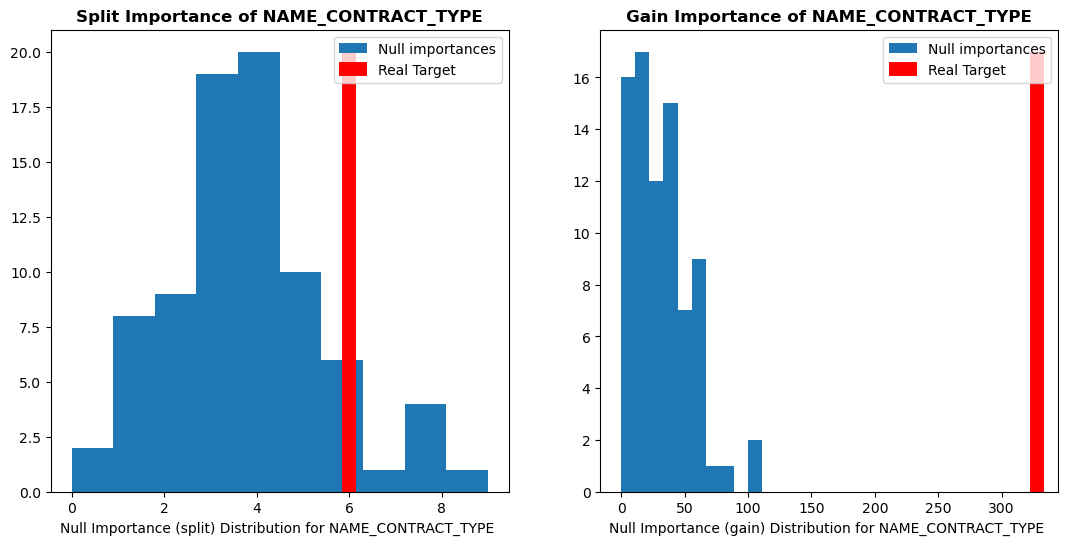

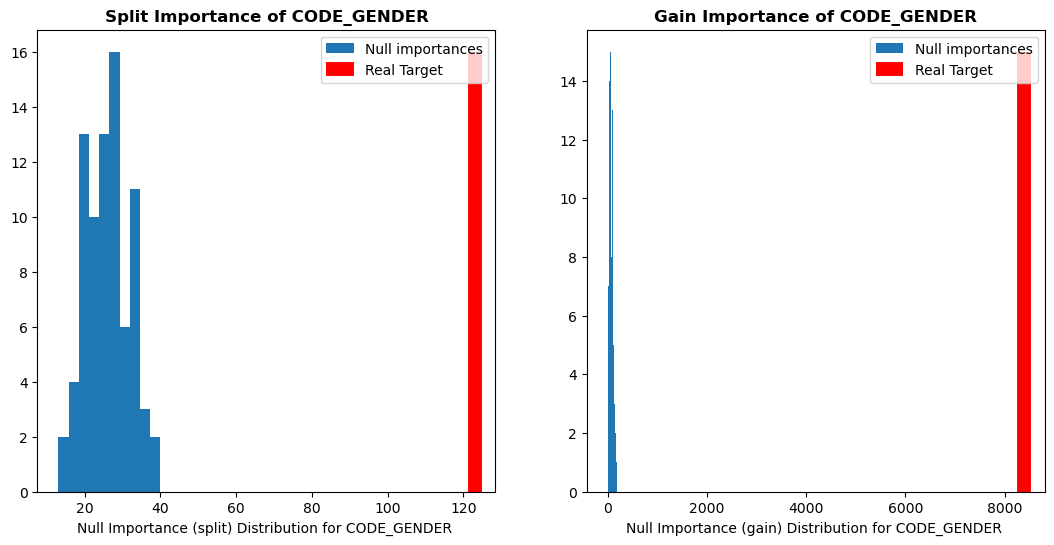

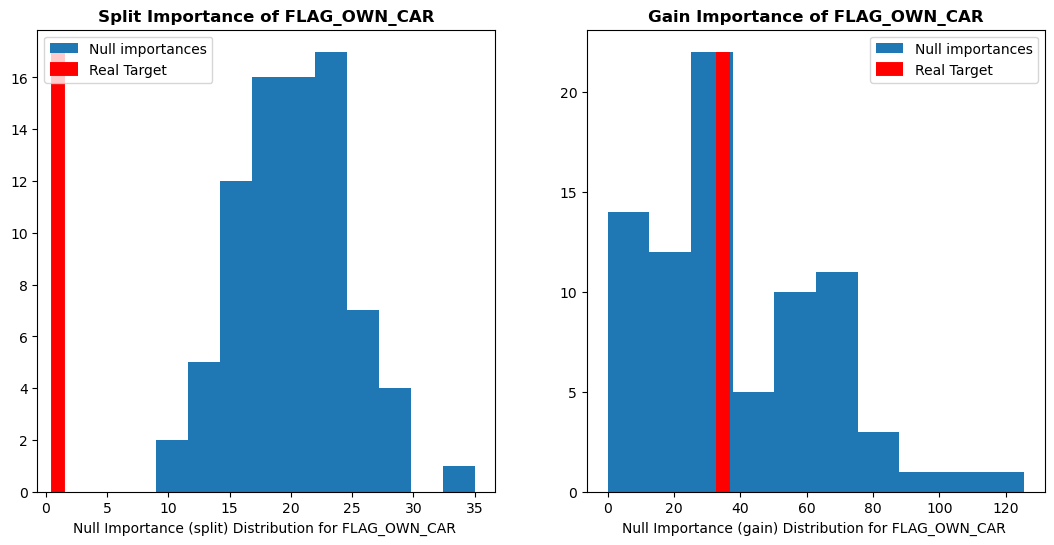

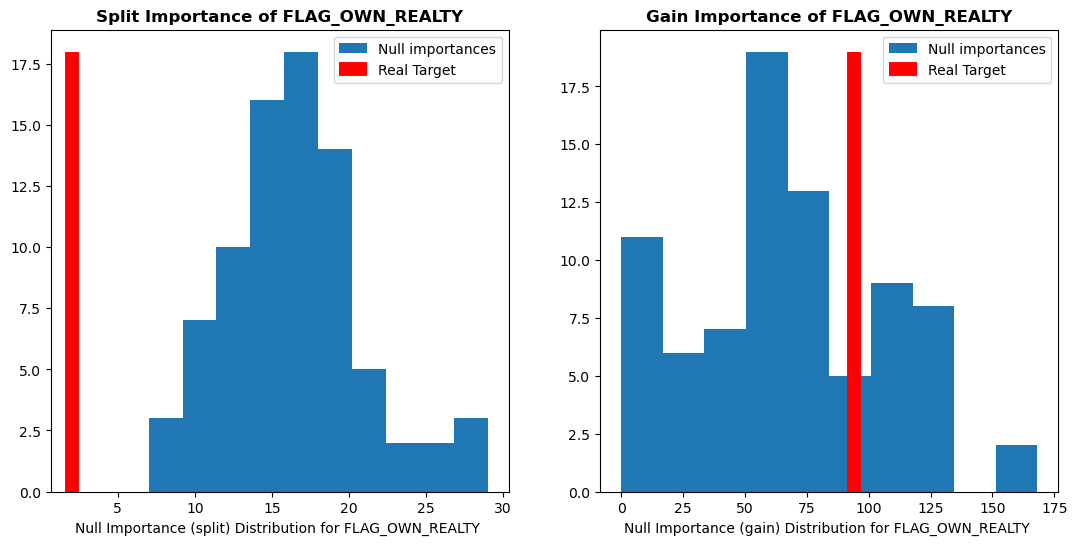

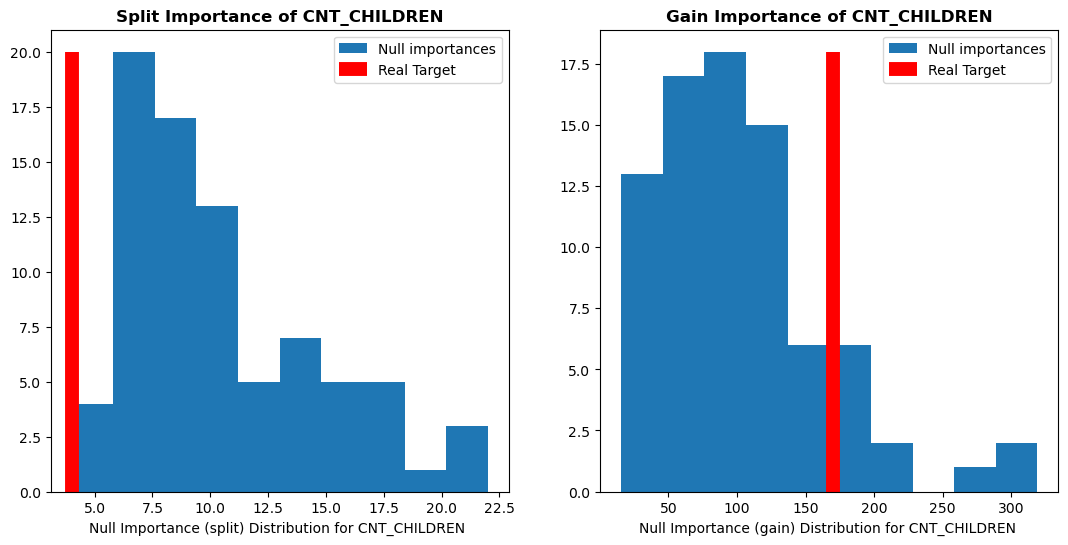

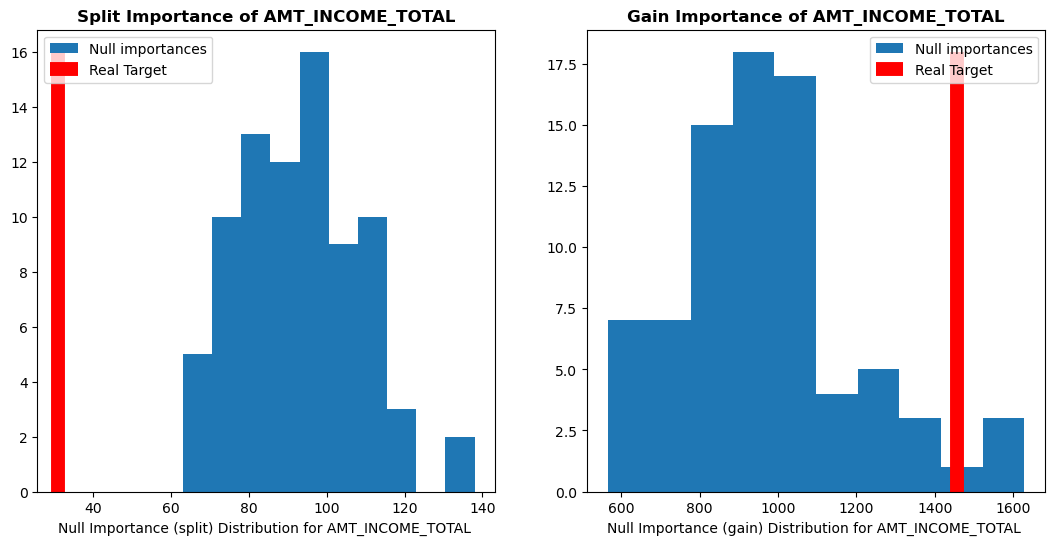

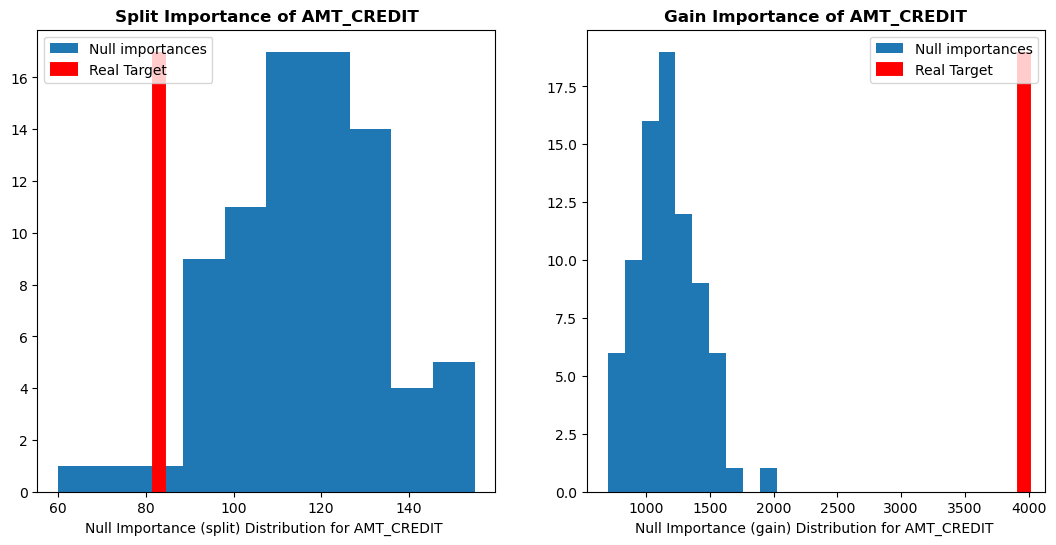

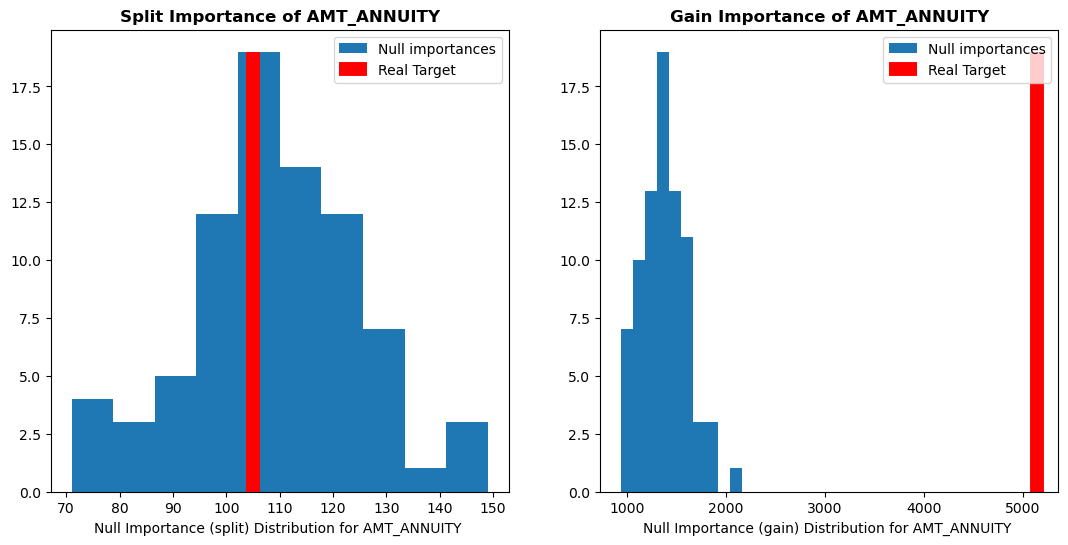

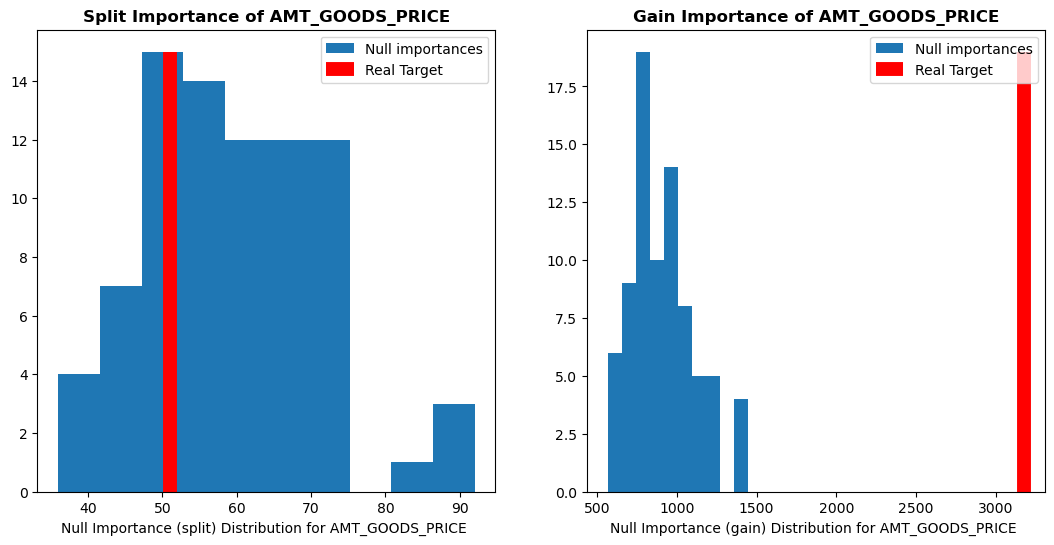

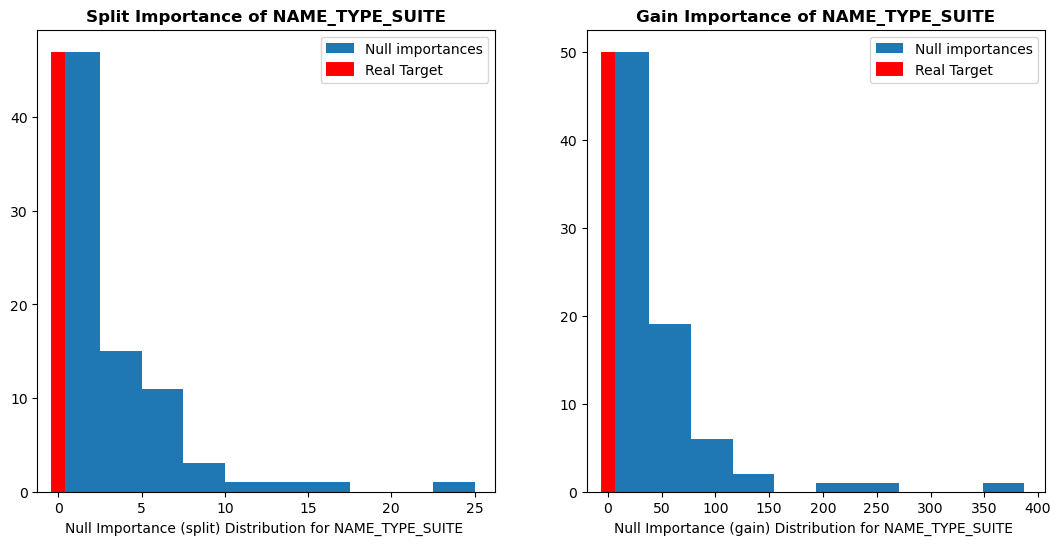

In [11]:
for feature in null_imp_df.feature[:10]:
    display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_=feature)

### Best features

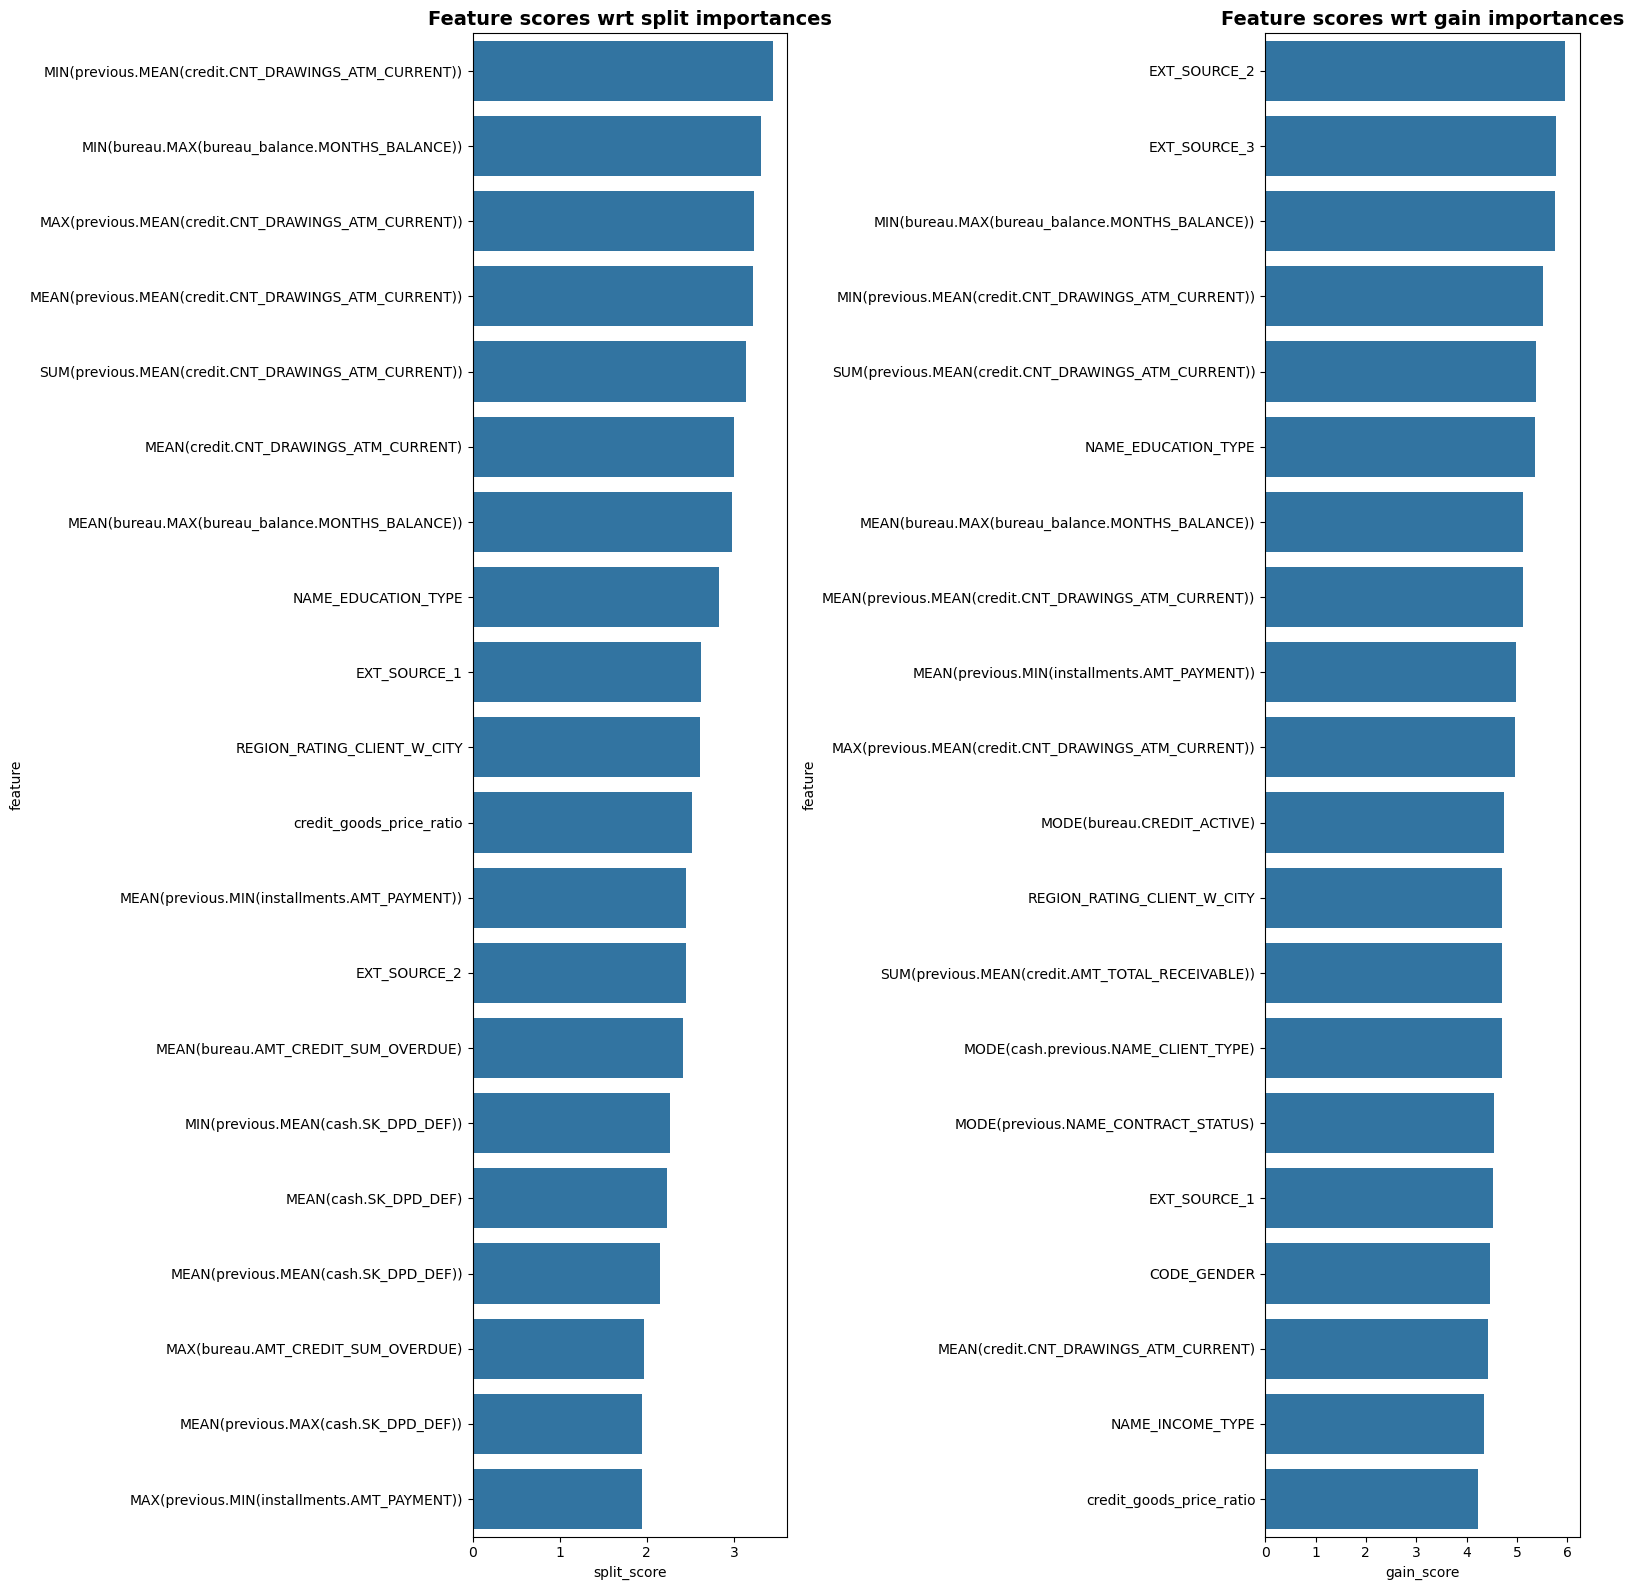

In [12]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    if f_null_imps_gain.size > 0:
        gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid divide by zero
    else:
        gain_score = -1
    
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    if f_null_imps_split.size > 0:
        split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid divide by zero
    else:
        split_score = -1
    
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:20], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:20], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout();


### Worst features

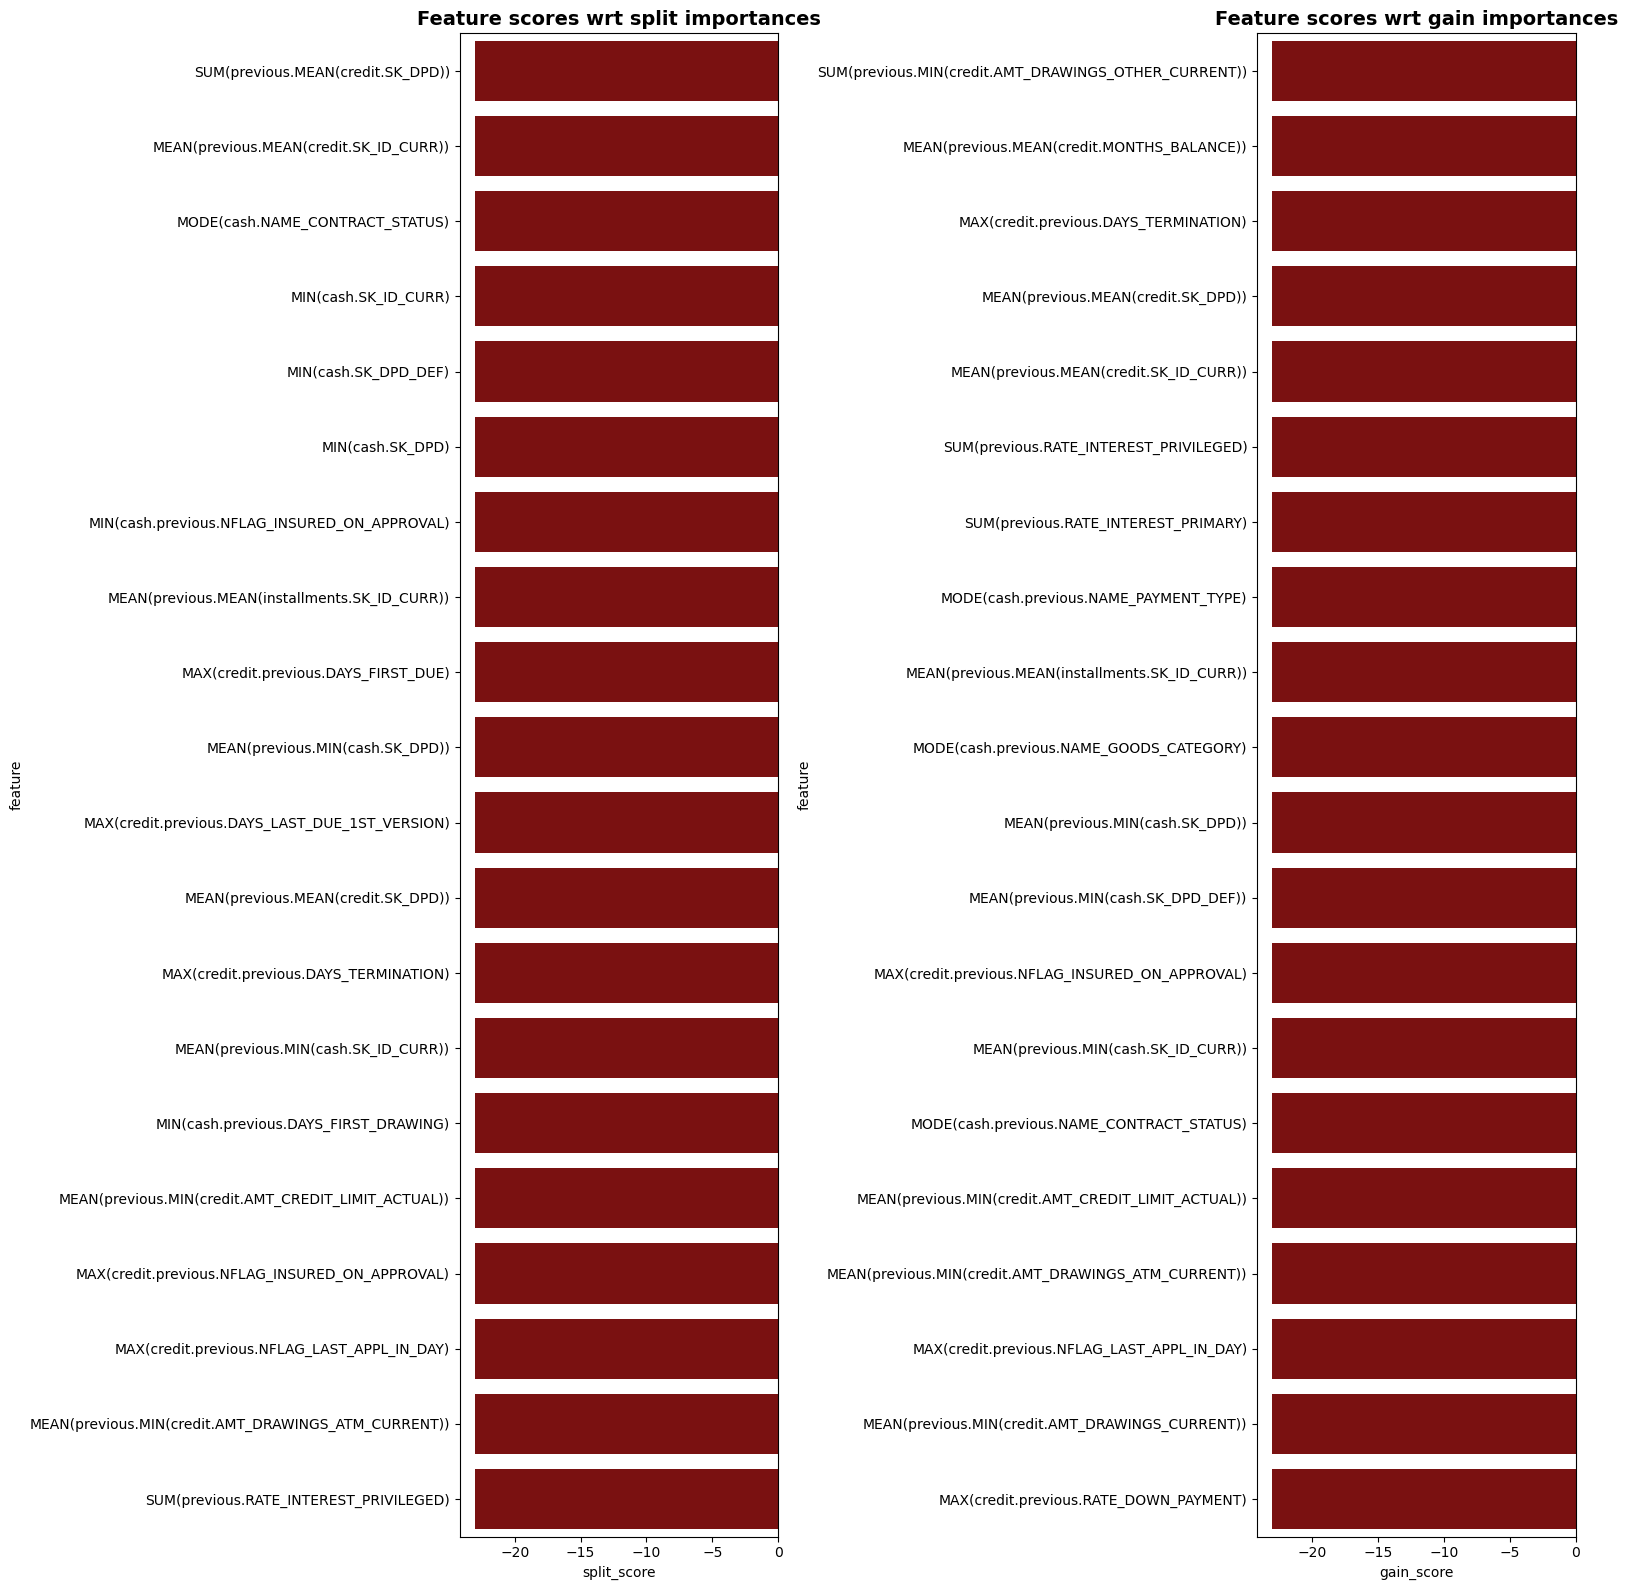

In [13]:
plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=True).iloc[0:20], ax=ax, color='darkred')
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=True).iloc[0:20], ax=ax, color='darkred')
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout();

### Removing useless features

In [14]:
split_score_threshold = -1
gain_score_threshold = 0

# Filter features based on thresholds
useful_features = scores_df[
    (scores_df['split_score'] > split_score_threshold) & 
    (scores_df['gain_score'] > gain_score_threshold)
]

# Optional: Remove features with extremely negative scores as a secondary filter
useful_features = useful_features[
    (useful_features['split_score'] > -5) & (useful_features['gain_score'] > -5)
]

len(useful_features)

# remove keep only useful features from feature matrix
feature_matrix_spec = feature_matrix_spec[["set", 'TARGET'] + useful_features.feature.to_list()]

601

#### Data preparation

In [15]:
from sklearn.model_selection import train_test_split

dummied_feature_matrix = pd.get_dummies(feature_matrix_spec)
len(dummied_feature_matrix.columns)

718

In [17]:
features = dummied_feature_matrix[dummied_feature_matrix["set_train"] == 1]
# features = features.sample(n = 50000, random_state = 42)

# Only numeric features
features = features.select_dtypes('number')

# Extract the labels
labels = np.array(features['TARGET'].astype(np.int32)).reshape((-1, ))
# features = features.drop(columns = ['TARGET'])

# filter features to only include top features
features = features[dummied_feature_matrix.columns.to_list()]

# Split into training and testing data
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state = 42)

# drop set_train and set_test columns
train_features = train_features.drop(columns = ['set_train', 'set_test'])
test_features = test_features.drop(columns = ['set_train', 'set_test'])

In [18]:
train_features.head()

,TARGET,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,...,MODE(cash.previous.NAME_CLIENT_TYPE)_New,MODE(cash.previous.NAME_CLIENT_TYPE)_Refreshed,MODE(cash.previous.NAME_CLIENT_TYPE)_Repeater,MODE(cash.previous.NAME_CLIENT_TYPE)_XNA,MODE(cash.previous.NAME_YIELD_GROUP)_high,MODE(cash.previous.NAME_YIELD_GROUP)_low_action,MODE(cash.previous.NAME_YIELD_GROUP)_low_normal,MODE(cash.previous.NAME_YIELD_GROUP)_middle,MODE(credit.previous.NAME_PRODUCT_TYPE)_walk-in,MODE(credit.previous.NAME_PRODUCT_TYPE)_x-sell
259386,0,539100.0,27652.5,450000.0,0.010147,-19802,-6322,-5503.0,-3336,NaN,...,0,0,1,0,0,0,0,1,0,0
63267,0,157500.0,7875.0,157500.0,0.011703,-15032,-127,-7331.0,-4563,NaN,...,0,0,0,0,0,0,0,0,0,0
16579,0,156384.0,16155.0,135000.0,0.010556,-19673,-3969,-6836.0,-3189,NaN,...,0,0,1,0,1,0,0,0,0,1
155405,0,443088.0,24034.5,382500.0,0.028663,-15839,-4227,-8333.0,-4238,NaN,...,0,0,0,0,0,0,0,0,0,1
53130,0,99000.0,5683.5,99000.0,0.031329,-18660,-173,-1951.0,-1674,NaN,...,1,0,0,0,1,0,0,0,0,0


In [19]:
# Separate features and target for the training data
X_train = train_features.drop(columns=['TARGET'])
y_train = train_features['TARGET']

# Separate features and target for the testing data
X_test = test_features.drop(columns=['TARGET'])
y_test = test_features['TARGET']

X_train = clean_feature_names(X_train)
X_test = clean_feature_names(X_test)

X_test = clean_feature_names(X_test)

# Replace infinite values with NaN
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

print('Final Train shape: ', X_train.shape)
print('Final Test shape: ', X_test.shape)

Final Train shape:  (230633, 715)
Final Test shape:  (76878, 715)


In [20]:
# save train and test to disk
X_train.to_csv('../training_data/X_train.csv', index=False)
y_train.to_csv('../training_data/y_train.csv', index=False)
X_test.to_csv('../training_data/X_test.csv', index=False)
y_test.to_csv('../training_data/y_test.csv', index=False)